In [18]:
import time
import copy

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from sklearn import metrics
import os
import pandas as pd
import cv2

#Load PlantDoc dataset

In [19]:
#Organizing the dataset
batch_size = 32
PlantPathology_data_dir = '../augmentation-validation/plant-pathology-2020-fgvc7'

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
train_on_gpu_mps = torch.backends.mps.is_available()

if train_on_gpu:
    print('CUDA is available.  Training on GPU ...')
    device = torch.device("cuda:0")
if train_on_gpu_mps:
    print('MPS is available!  Training on GPU ...')
    device = torch.device("mps")
else:
    print('Training on CPU ...')
    device = torch.device("cpu")
print(device)

MPS is available!  Training on GPU ...
mps


In [20]:
class PlantDataset(Dataset):
    
    def __init__(self, df, transforms=None):
    
        self.df = df
        self.transforms=transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        image_src = PlantPathology_data_dir + '/images/' + self.df.loc[idx, 'image_id'] + '.jpg'
        image = Image.open(image_src)
        labels = np.argmax(self.df.loc[idx, ['healthy', 'rust', 'scab']].values)
        labels = torch.tensor(labels.astype(np.int8))
        
        if self.transforms:
            image = self.transforms(image)

        return image, labels

In [21]:
PlantPathology_data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_df = pd.read_csv(PlantPathology_data_dir + '/train.csv')
train_df = train_df.drop(train_df[train_df['multiple_diseases'] == 1].index, axis=0)
train_df = train_df.drop('multiple_diseases', axis=1)
train_df.reset_index(inplace=True)
train_df = train_df.drop('index', axis=1)

train_labels = train_df.iloc[:, 1:].values

In [22]:
PlantPathology_dataset_train = PlantDataset(df=train_df, transforms=PlantPathology_data_transforms['train'])
PlantPathology_dataloader_train = DataLoader(PlantPathology_dataset_train, batch_size=batch_size, shuffle=False)

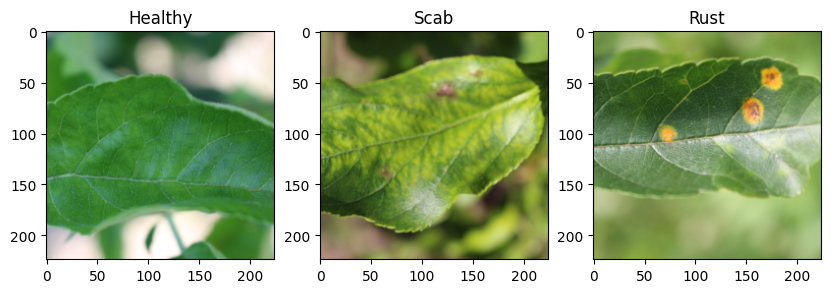

In [23]:
num_show = 4
fig, axs = plt.subplots(1,3, figsize=(10,10))
axs[0].imshow(np.transpose(PlantPathology_dataset_train[1][0].numpy(), (1,2,0)))
axs[0].set_title('Healthy')
axs[1].imshow(np.transpose(PlantPathology_dataset_train[0][0].numpy(), (1,2,0)))
axs[1].set_title('Scab')
axs[2].imshow(np.transpose(PlantPathology_dataset_train[2][0].numpy(), (1,2,0)))
axs[2].set_title('Rust')
plt.show()

# Load PlantVillage classifier

In [24]:
def get_dataset(data_dir, splits, data_transforms):
  # Define your transforms for the training and validation sets
  # Data augmentation and normalization for training
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in splits}

  balance_classes = False

  # Using the image datasets and the trainforms, define the dataloaders
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in splits}

  dataset_sizes = {x: len(image_datasets[x]) for x in splits}

  return dataloaders, image_datasets

In [25]:
PlantVillage_data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        # transforms.RandomAffine(0,shear=30),
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
PlantVillage_data_dir = '../augmentation-validation/original-dataset/PlantVillage'
PlantVillage_splits = ['train', 'val']
PlantVillage_dataloaders, PlantVillage_datasets = get_dataset(PlantVillage_data_dir, PlantVillage_splits, PlantVillage_data_transforms)

In [30]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device('mps'))
    model = models.resnet50()
    
    # Input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 38
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_size, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, output_size)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

    model.fc = classifier
    model.load_state_dict(checkpoint['state_dict'])
    
    return model
# checkpoint_path = '../augmentation-validation/plantvillage_traditional_resnet50.pth'
# checkpoint_path = '../augmentation-validation/plantvillage_original_resnet50.pth'
checkpoint_path = '../augmentation-validation/plantvillage_nst_resnet50.pth'

# Get index to class mapping
loaded_model = load_checkpoint(checkpoint_path)

In [31]:
# Do validation on the test set
def test(model, dataloader, device, pred_classes, train_to_val_classes, apple_indices):
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  predicted_labels = []
  true_labels = []

  for images, labels in dataloader:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
    output = model.forward(images)
    ps = torch.exp(output).data.cpu().numpy()
    ps = np.argsort(ps,axis=1)[:,::-1]
    ps_H, ps_W = ps.shape
    ps_apples = np.zeros((ps_H, len(apple_indices)),dtype=np.uint8)
    for row in range(ps_H):
      ps_apples[row,:] = np.array([ps[row,col] for col in range(ps_W) if ps[row,col] in apple_indices])

    ps_apples = ps_apples[:,0].squeeze()
    pred = []
    for i,x in enumerate(labels.data):
      predicted_label = ps_apples[i]
      predicted_class = pred_classes[predicted_label]
      predicted_val_label = train_to_val_classes[predicted_class]
      pred.append(predicted_val_label)
      predicted_labels.append(predicted_val_label)
      true_labels.append(x)
    
    # print(pred)
    pred = torch.FloatTensor(pred).to(device)
    equality = (labels.data == pred)
    acc = equality.type_as(torch.FloatTensor())
    accuracy += acc.mean()

  print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloader)))

  return true_labels, predicted_labels

In [32]:
PlantVillage_to_PlantPathology_classes = {
 'Apple___healthy' : 3,
 'Apple___Cedar_apple_rust' : 2,
 'Apple___Apple_scab' : 1,
}
pred_classes = PlantVillage_datasets['train'].classes.copy()
print(pred_classes)
apple_indices = [pred_classes.index(x) for x in PlantVillage_to_PlantPathology_classes]
print(apple_indices)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [33]:
true_labels, predicted_labels = test(loaded_model, PlantPathology_dataloader_train, device, pred_classes, PlantVillage_to_PlantPathology_classes, apple_indices)
predicted_labels_list = [x for x in predicted_labels]
true_labels_list = [x.cpu().item() for x in true_labels]

KeyboardInterrupt: 

## CycleGAN augmentation


In [ ]:
# Print the confusion matrix
print(metrics.confusion_matrix(true_labels_list, predicted_labels_list))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_labels_list, predicted_labels_list, target_names=list(PlantVillage_to_PlantPathology_classes.keys()), digits=3))

[[257  86 173]
 [ 25 543  54]
 [ 44 153 395]]
                          precision    recall  f1-score   support

         Apple___healthy      0.788     0.498     0.610       516
Apple___Cedar_apple_rust      0.694     0.873     0.774       622
      Apple___Apple_scab      0.635     0.667     0.651       592

                accuracy                          0.691      1730
               macro avg      0.706     0.679     0.678      1730
            weighted avg      0.702     0.691     0.683      1730



## NST augmentation


In [17]:
# Print the confusion matrix
print(metrics.confusion_matrix(true_labels_list, predicted_labels_list))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_labels_list, predicted_labels_list, target_names=list(PlantVillage_to_PlantPathology_classes.keys()), digits=3))

[[  0  10   0 506]
 [  0  27   3 592]
 [  0 112   0 480]
 [  0   0   0   0]]


ValueError: Number of classes, 4, does not match size of target_names, 3. Try specifying the labels parameter

## Simple data augmentation without class balancing


In [ ]:
# Print the confusion matrix
print(metrics.confusion_matrix(true_labels_list, predicted_labels_list))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_labels_list, predicted_labels_list, target_names=list(PlantVillage_to_PlantPathology_classes.keys()), digits=3))

[[274   9 233]
 [ 23 417 182]
 [ 25  10 557]]
                          precision    recall  f1-score   support

         Apple___healthy      0.851     0.531     0.654       516
Apple___Cedar_apple_rust      0.956     0.670     0.788       622
      Apple___Apple_scab      0.573     0.941     0.712       592

                accuracy                          0.721      1730
               macro avg      0.793     0.714     0.718      1730
            weighted avg      0.794     0.721     0.722      1730



## Simple data augmentation with class balancing

In [ ]:
# Print the confusion matrix
print(metrics.confusion_matrix(true_labels_list, predicted_labels_list))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_labels_list, predicted_labels_list, target_names=list(PlantVillage_to_PlantPathology_classes.keys()), digits=3))

[[258   8 250]
 [ 21 356 245]
 [ 53  48 491]]
                          precision    recall  f1-score   support

         Apple___healthy      0.777     0.500     0.608       516
Apple___Cedar_apple_rust      0.864     0.572     0.689       622
      Apple___Apple_scab      0.498     0.829     0.622       592

                accuracy                          0.639      1730
               macro avg      0.713     0.634     0.640      1730
            weighted avg      0.713     0.639     0.642      1730



## No data augmentation

In [ ]:
# Print the confusion matrix
print(metrics.confusion_matrix(true_labels_list, predicted_labels_list))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_labels_list, predicted_labels_list, target_names=list(PlantVillage_to_PlantPathology_classes.keys()), digits=3))

[[481   6  29]
 [180 375  67]
 [284  16 292]]
                          precision    recall  f1-score   support

         Apple___healthy      0.509     0.932     0.658       516
Apple___Cedar_apple_rust      0.945     0.603     0.736       622
      Apple___Apple_scab      0.753     0.493     0.596       592

                accuracy                          0.664      1730
               macro avg      0.735     0.676     0.663      1730
            weighted avg      0.749     0.664     0.665      1730

